## Building the graph

### Clipping: Considerating only Javascript mentions

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [170]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [171]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [172]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [173]:
#Only javascript mentions
data = data[data['BODY'].notna() & (data['BODY'].str.lower().str.contains('js', case=False) | data['BODY'].str.lower().str.contains('javascript', case=False))]


In [174]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [175]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
33,jc00ke,2015-01-01T00:18:37Z,"```ruby\r\nbody = {\r\n name: ""event"",\r\n s...",botandrose
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
45,mnquintana,2015-01-01T00:23:59Z,It seemed to be a bug with jshint's globbing -...,YaleSTC
56,jbrooksuk,2015-01-01T00:29:06Z,Move the JS into start.js please.,Jamesking56
...,...,...,...,...
635061,kuba,2015-02-28T08:30:06Z,That's because we want to use `cls.from_valid_...,letsencrypt
635113,mrjoelkemp,2015-02-28T08:43:50Z,What about 'index.js' as a path? Wouldn't that...,mrjoelkemp
635126,rexxarM,2015-02-28T08:48:18Z,@kennytm does iOS support this way to invoke ...,hihex
635146,kennytm,2015-02-28T08:55:51Z,iOS WebView supports this if the via URL captu...,hihex


In [176]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
codeschool-kiddo    768
linthubot           332
jirikuncar           81
vladberteanu         61
sindresorhus         59
                   ... 
WebSeed               1
WedgeSama             1
jhansche              1
jhamman               1
zzcclp                1
Name: source, Length: 6860, dtype: int64

In [177]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    6860.000000
mean        2.567638
std        10.749420
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       768.000000
Name: source, dtype: float64

In [178]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['deadlyvipers', 'mozilla', 'iojs', 'mozilla-b2g', 'nl5887', 'edx',
       'angular', 'Wikia', 'apache', 'jquery',
       ...
       'LaunchAcademy', 'OSCModulator', 'BrandwatchLtd',
       'D-Programming-Language', 'BlockServerProject', 'Behat', 'ElbertF',
       'KhanovaSkola', 'DeDiS', '28msec'],
      dtype='object', name='source', length=695)

In [179]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [180]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
22,orenyk,2015-01-01T00:13:41Z,any reason why we're not excluding `vendor` he...,YaleSTC
42,codeschool-kiddo,2015-01-01T00:22:52Z,Looks good! Could you also please mention your...,deadlyvipers
45,mnquintana,2015-01-01T00:23:59Z,It seemed to be a bug with jshint's globbing -...,YaleSTC
298,bors-servo,2015-01-01T10:00:43Z,merging yodalee/servo/issue4484-ToJSValConvert...,servo
299,bors-servo,2015-01-01T10:00:44Z,yodalee/servo/issue4484-ToJSValConvertible-for...,servo
...,...,...,...,...
634903,Honry,2015-02-28T07:16:45Z,"This step name elusive, here you want to click...",crosswalk-project
634934,cpq,2015-02-28T07:31:52Z,Dead code removed.\r\nJS implementation is wro...,cesanta
635061,kuba,2015-02-28T08:30:06Z,That's because we want to use `cls.from_valid_...,letsencrypt
635113,mrjoelkemp,2015-02-28T08:43:50Z,What about 'index.js' as a path? Wouldn't that...,mrjoelkemp


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [181]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [182]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
maxogden            0.000186
rmzelle             0.000260
splendido           0.000260
d10                 0.000260
phated              0.000260
                      ...   
bajtos              0.070402
vladberteanu        0.079427
jirikuncar          0.105469
linthubot           0.424514
codeschool-kiddo    1.000000
Name: source, Length: 3104, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [183]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
18F              [afeld, cmc333333, konklone, maxogden, mbland,...
201-created                                        [bantic, iezer]
2600hz                                    [jamesaimonetti, macpie]
28msec                                      [dknochen, wcandillon]
2gis                                               [NickAb, Trufi]
                                       ...                        
zestedesavoir         [Alex-D, Situphen, artragis, firm1, gustavi]
zlenyk                                                    [Anitka]
zooniverse             [aweiksnar, camallen, chrissnyder, edpaget]
zotero           [aurimasv, dstillman, fbennett, nemobis, reubo...
zxqfox                                             [eGavr, zxqfox]
Name: AUTHOR, Length: 695, dtype: object

In [184]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [185]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 3071


#### Number of edges in the graph

In [186]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 24537


#### Density of the graph

In [187]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

4713985

In [188]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.0052051502073086784


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [189]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [190]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
afeld,0.000868,2
cmc333333,0.001302,1
konklone,0.001736,2
maxogden,0.000186,1
mbland,0.001302,1


##### Adding clustering and degree metrics

In [191]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,3071.000000,3071.000000,3071.000000,3071.000000
mean,0.004691,3.771084,0.868897,0.005205
std,0.020447,15.781943,0.318126,0.007729
min,0.000186,1.000000,0.000000,0.000326
25%,0.001302,1.000000,1.000000,0.000977
50%,0.002604,2.000000,1.000000,0.001954
75%,0.005208,4.000000,1.000000,0.005537
max,1.000000,768.000000,1.000000,0.050814


In [192]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,3071.000000
mean,15.979811
std,23.729109
min,1.000000
25%,3.000000
50%,6.000000
75%,17.000000
max,156.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

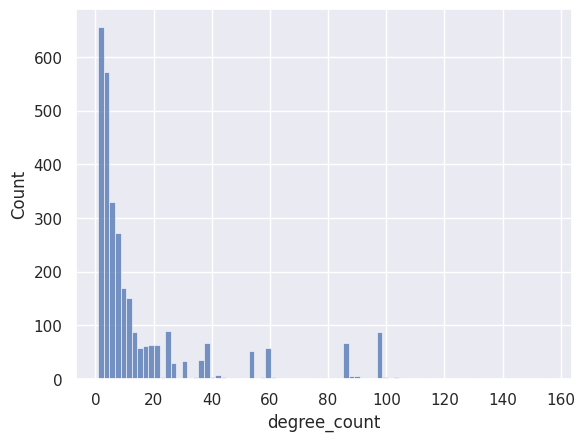

In [193]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [194]:
selRows = data[data['colabs'] > 1000].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [195]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [196]:
data['degree'].describe().to_frame()

,degree
count,3071.000000
mean,0.005205
std,0.007729
min,0.000326
25%,0.000977
50%,0.001954
75%,0.005537
max,0.050814


In [197]:
data['focus'].describe().to_frame()

,focus
count,3.071000e+03
mean,4.506120e-03
std,2.045094e-02
min,1.000000e-10
25%,1.116279e-03
50%,2.418605e-03
75%,5.023256e-03
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

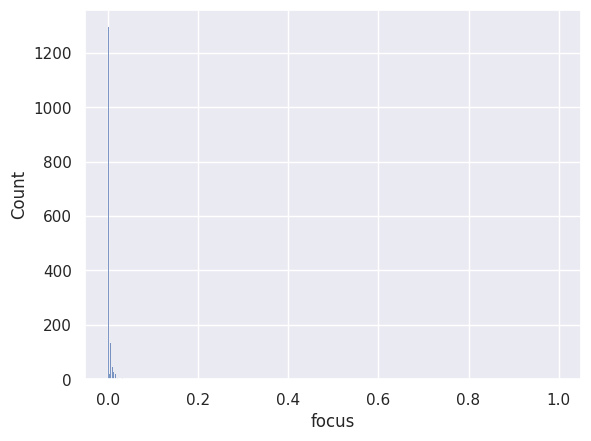

In [198]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

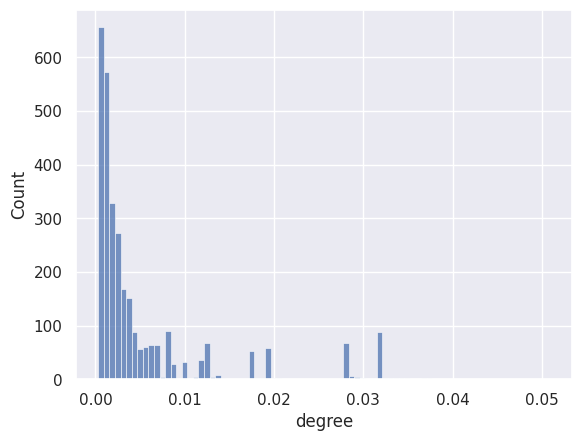

In [199]:
sns.histplot(data['degree'])

In [200]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

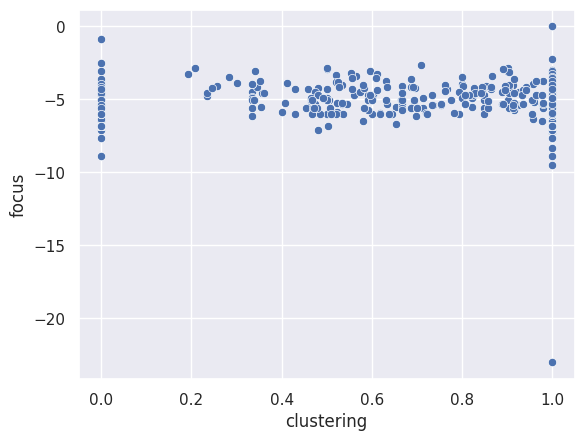

In [201]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [202]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
codeschool-kiddo,1.000000e+00,768,1.000000,0.003909,12
linthubot,4.244074e-01,329,0.000000,0.000326,1
jirikuncar,1.053023e-01,81,1.000000,0.002280,7
vladberteanu,7.925581e-02,61,0.000000,0.000326,1
bajtos,7.022935e-02,56,0.707991,0.033876,104
...,...,...,...,...,...
splendido,7.441870e-05,1,1.000000,0.003257,10
d10,7.441870e-05,1,1.000000,0.001629,5
rmzelle,7.441870e-05,1,1.000000,0.001954,6


### Residuals

In [203]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [204]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.329
Date:                Thu, 08 Jun 2023   Prob (F-statistic):            0.00227
Time:                        18:58:29   Log-Likelihood:                 7592.9
No. Observations:                3071   AIC:                        -1.518e+04
Df Residuals:                    3069   BIC:                        -1.517e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0076      0.001      7.071      0.000       0.005       0.010
clustering    -0.0035      0.001     -3.054      0.002      -0.006      -0.001
==============================================================================
Omnibus:                     9048.795   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        461788795.918
Skew:                          40.717   Prob(JB):                         0.00
Kurtosis:                    1900.964   Cond. No.                         5.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [205]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.003539,0.001159,0.002275


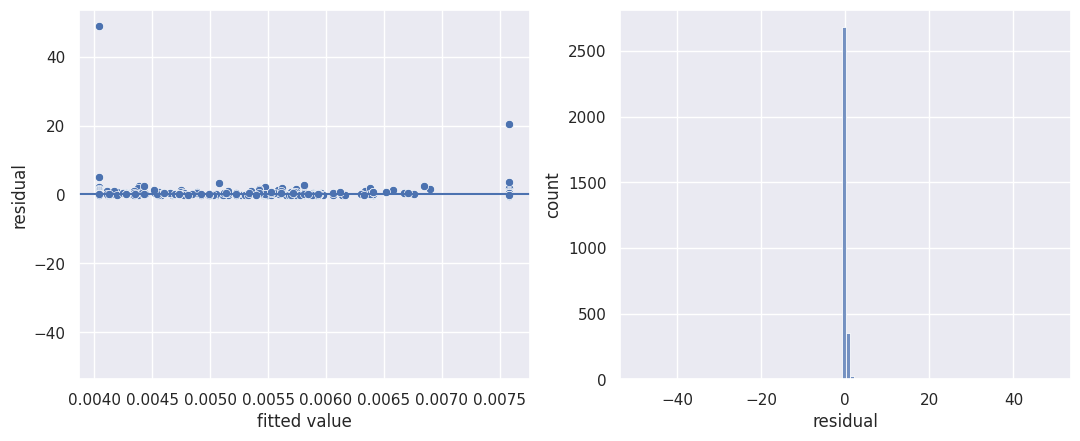

In [206]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [207]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [208]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     115.3
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           5.46e-49
Time:                        18:58:31   Log-Likelihood:                -4281.1
No. Observations:                3071   AIC:                             8568.
Df Residuals:                    3068   BIC:                             8586.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4702      0.051   -106.539      0.000      -5.571      -5.370
clustering    -0.7776      0.056    -13.827      0.000      -0.888      -0.667
degree        19.9149      2.315      8.603      0.000      15.376      24.454
==============================================================================
Omnibus:                     1328.417   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           109580.404
Skew:                          -1.149   Prob(JB):                         0.00
Kurtosis:                      32.174   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.777635,0.056240,0.000000
degree,19.914874,2.314758,0.000000


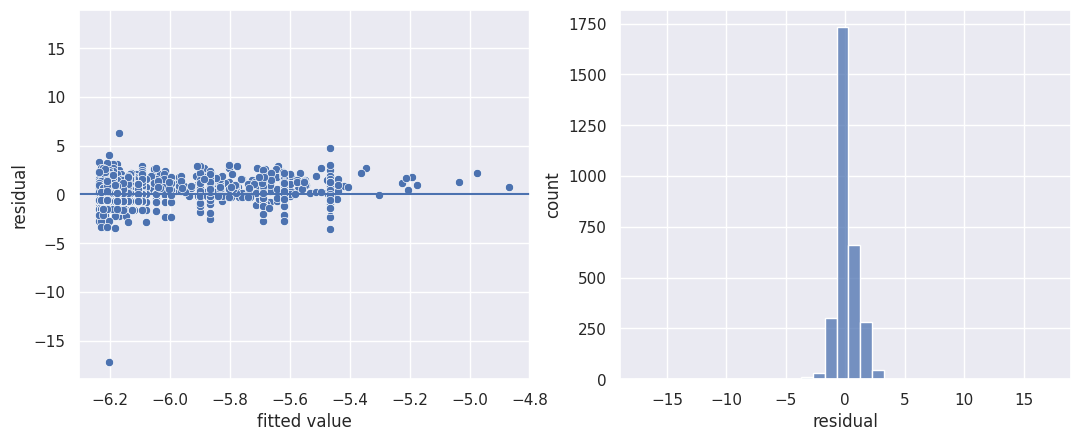

In [210]:
result.plot_residuals()

## Saving the graph

In [211]:
import netpixi

In [212]:
gt_save(g, '../networks/colabs_js.net.gz')